In [1]:
import warnings
warnings.filterwarnings('ignore')

import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from Account import Account
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import datetime as dt

In [2]:
mid_cap = pd.read_csv('../data/mid_cap_index.csv')
sp500_list = list(mid_cap['Symbol'])

In [3]:
len(sp500_list)

399

In [4]:
sp500_historical = {}
for ticker in sp500_list:
    try:
        sp500_historical[ticker] = si.get_data(
            ticker, 
            start_date="01/01/2019", 
            end_date="22/07/2022",
            index_as_date = False, 
            interval="1d"
        )
    except:
        pass
print(len(sp500_historical))
sp_500_df = si.get_data(
    'SPY', 
    start_date="01/01/2019",
    end_date="22/07/2022", 
    index_as_date = True, 
    interval="1d"
)

391


In [5]:
for ticker in sp500_historical:
    sp500_historical[ticker]['pct_change_open'] = sp500_historical[ticker]['open'].pct_change()
    sp500_historical[ticker]['five_day_mean'] = sp500_historical[ticker]['pct_change_open'].rolling(5).mean()
    sp500_historical[ticker]['five_day_var'] = sp500_historical[ticker]['pct_change_open'].rolling(5).var()
    sp500_historical[ticker]['twenty_day_mean'] = sp500_historical[ticker]['pct_change_open'].rolling(20).mean()
    sp500_historical[ticker]['twenty_day_var'] = sp500_historical[ticker]['pct_change_open'].rolling(20).var()

In [6]:
sp_df = None
for ticker in sp500_historical:
    if sp_df is not None:
        sp_df = pd.concat([sp_df, sp500_historical[ticker]])
    else:
        sp_df = sp500_historical[ticker]
sp_df.set_index('date', inplace=True)
sp_df.sort_index(inplace=True)
sp_df

,open,high,low,close,adjclose,volume,ticker,pct_change_open,five_day_mean,five_day_var,twenty_day_mean,twenty_day_var
date,,,,,,,,,,,,
2019-01-02,35.380001,37.470001,34.830002,36.740002,31.137312,3183000,TRGP,NaN,NaN,NaN,NaN,NaN
2019-01-02,3.189260,3.392272,3.143418,3.320236,3.320236,1803692,SPWR,NaN,NaN,NaN,NaN,NaN
2019-01-02,35.369999,36.279999,35.110001,36.009998,30.987766,1379700,LEG,NaN,NaN,NaN,NaN,NaN
2019-01-02,44.570000,44.810001,43.470001,43.740002,43.740002,496800,IART,NaN,NaN,NaN,NaN,NaN
2019-01-02,44.599998,45.490002,44.060001,44.720001,39.709064,452700,ENR,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-21,29.459999,30.559999,29.160000,30.420000,30.342670,5659200,RRC,0.050267,0.026151,0.000354,0.008551,0.001986
2022-07-21,66.370003,68.150002,66.370003,68.139999,67.625504,141200,GEF,-0.000452,0.018812,0.000392,0.006528,0.000507
2022-07-21,39.000000,39.779999,38.639999,39.500000,39.165005,1642100,SNV,0.018543,0.023688,0.000125,0.005305,0.000468


In [7]:
len(sp_df['ticker'].unique())

391

In [8]:
for col in sp_df.columns:
    print(col)

open
high
low
close
adjclose
volume
ticker
pct_change_open
five_day_mean
five_day_var
twenty_day_mean
twenty_day_var


In [9]:
dates = sp_df.index.unique()
dates = dates[25:390]
dates

DatetimeIndex(['2019-02-07', '2019-02-08', '2019-02-11', '2019-02-12',
               '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-19',
               '2019-02-20', '2019-02-21',
               ...
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-20'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)

In [10]:
def find_centers(df_0, df_1, df_2, df_3, time='close'):
    """
    df0-3(dataframe): dataframes of centroids
    """
    poss_td = []
    poss_tu = []
    poss_mrd = []
    poss_mru = []
    tu_cent, td_cent, mru_cent, mrd_cent = None, None, None, None
    
    cent_0 = {
        'name': 0,
        f'pct_change_{time}': df_0[f'pct_change_{time}'].mean(),
        'five_day_mean': df_0['five_day_mean'].mean(),
        'five_day_var': df_0['five_day_var'].mean(),
        'twenty_day_mean': df_0['twenty_day_mean'].mean(),
        'twenty_day_var': df_0['twenty_day_var'].mean(),
        'trend_score': df_0[f'pct_change_{time}'].mean() + df_0['five_day_mean'].mean(),
        'mean_revert_score': df_0['five_day_mean'].mean() - df_0[f'pct_change_{time}'].mean()
    }

    cent_1 = {
        'name': 1,
        f'pct_change_{time}': df_1[f'pct_change_{time}'].mean(),
        'five_day_mean': df_1['five_day_mean'].mean(),
        'five_day_var': df_1['five_day_var'].mean(),
        'twenty_day_mean': df_1['twenty_day_mean'].mean(),
        'twenty_day_var': df_1['twenty_day_var'].mean(),
        'trend_score': df_1[f'pct_change_{time}'].mean() + df_1['five_day_mean'].mean(),
        'mean_revert_score': df_1['five_day_mean'].mean() - df_1[f'pct_change_{time}'].mean() 
    }

    cent_2 = {
        'name': 2,
        f'pct_change_{time}': df_2[f'pct_change_{time}'].mean(),
        'five_day_mean': df_2['five_day_mean'].mean(),
        'five_day_var': df_2['five_day_var'].mean(),
        'twenty_day_mean': df_2['twenty_day_mean'].mean(),
        'twenty_day_var': df_2['twenty_day_var'].mean(),
        'trend_score': df_2[f'pct_change_{time}'].mean() + df_2['five_day_mean'].mean(),
        'mean_revert_score': df_2['five_day_mean'].mean() - df_2[f'pct_change_{time}'].mean() 
    }

    cent_3 = {
        'name': 3,
        f'pct_change_{time}': df_3[f'pct_change_{time}'].mean(),
        'five_day_mean': df_3['five_day_mean'].mean(),
        'five_day_var': df_3['five_day_var'].mean(),
        'twenty_day_mean': df_3['twenty_day_mean'].mean(),
        'twenty_day_var': df_3['twenty_day_var'].mean(),
        'trend_score': df_3[f'pct_change_{time}'].mean() + df_3['five_day_mean'].mean(),
        'mean_revert_score': df_3['five_day_mean'].mean() - df_3[f'pct_change_{time}'].mean() 
    }

    cents = [cent_0, cent_1, cent_2, cent_3]

    for cent in cents:
        if cent[f'pct_change_{time}'] < 0 and cent['five_day_mean'] < 0:
            poss_td.append(cent)
        elif cent[f'pct_change_{time}'] > 0 and cent['five_day_mean'] > 0:
            poss_tu.append(cent)
        elif cent[f'pct_change_{time}'] > 0 and cent['five_day_mean'] < 0:
            poss_mrd.append(cent)
        elif cent[f'pct_change_{time}'] < 0 and cent['five_day_mean'] > 0:
            poss_mru.append(cent)
    
    cents = []
    if len(poss_td) == 1:
        td_cent = poss_td[0]
    elif len(poss_td) > 1:
        poss_td = sorted(poss_td, key=lambda x: x['trend_score'])
        td_cent = poss_td[0]
        cents += poss_td[1:]
    if len(poss_tu) == 1:
        tu_cent = poss_tu[0]
    elif len(poss_tu) > 1:
        poss_tu = sorted(poss_tu, key=lambda x: x['trend_score'], reverse=True)
        tu_cent = poss_tu[0]
        cents += poss_tu[1:]
    if len(poss_mrd) == 1:
        mrd_cent = poss_mrd[0]
    elif len(poss_mrd) > 1:
        poss_mrd = sorted(poss_mrd, key=lambda x: x['mean_revert_score'])
        mrd_cent = poss_mrd[0]
        cents += poss_mrd[1:]
    if len(poss_mru) == 1:
        mru_cent = poss_mru[0]
    elif len(poss_mru) > 1:
        poss_mru = sorted(poss_mru, key=lambda x: x['mean_revert_score'], reverse=True)
        mru_cent = poss_mru[0]
        cents += poss_mru[1:]

    if len(cents) == 0:
        return tu_cent, td_cent, mru_cent, mrd_cent
    
    if td_cent is None:
        cents = sorted(cents, key=lambda x: x['trend_score'])
        td_cent = cents[0]
        if len(cents) == 1:
            return tu_cent, td_cent, mru_cent, mrd_cent
        cents = cents[1:]
    
    if tu_cent is None:
        cents = sorted(cents, key=lambda x: x['trend_score'], reverse=True)
        tu_cent = cents[0]
        if len(cents) == 1:
            return tu_cent, td_cent, mru_cent, mrd_cent
        cents = cents[1:]

    if mrd_cent is None:
        cents = sorted(cents, key=lambda x: x['mean_revert_score'])
        mrd_cent = cents[0]
        if len(cents) == 1:
            return tu_cent, td_cent, mru_cent, mrd_cent
        cents = cents[1:]
    
    if mru_cent is None:
        mru_cent = cents[0]
    
    return tu_cent, td_cent, mru_cent, mrd_cent

start date:  2019-02-07 00:00:00
end date:  2020-07-20 00:00:00
Profit:  -3843.2767817378044
Annualized Returns:  -0.026678573707282327
Winrate:  0.49193548387096775
Percent Gain on Winning Trades:  0.5579364508696558
Percent Loss on Losing Trades:  0.4432422550311887
Sharpe Ratio:  -0.11204635805294594
Max drawdown:  31528.43532782793
Max drawdown length:  281
Alpha:  -0.004564677027733534


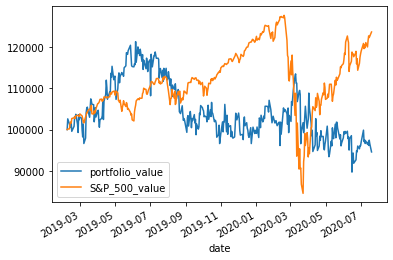

In [11]:
account = Account(100000, time='open')
print("start date: ", dates[0])
print("end date: ", dates[-1])
time='open'
for i in range(len(dates)):
    sample_df = sp_df.loc[dates[i]]
    if i > 0 and time == 'close':
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])
    
    # Updating strategy after close
    hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    sample_df = sample_df[
        ~sample_df[[f'pct_change_{time}', 
        'five_day_mean', 
        'five_day_var', 
        'twenty_day_mean', 
        'twenty_day_var'
        ]].isin([np.nan, np.inf, -np.inf]).any(1)]

    sample_df['cluster'] = hc.fit_predict(sample_df[[f'pct_change_{time}', 'five_day_mean']])
    df_0 = sample_df[sample_df['cluster'] == 0]
    df_0.name = 0
    df_1 = sample_df[sample_df['cluster'] == 1]
    df_1.name = 1
    df_2 = sample_df[sample_df['cluster'] == 2]
    df_2.name = 2
    df_3 = sample_df[sample_df['cluster'] == 3]
    df_3.name = 3

    tu_cent, td_cent, mru_cent, mrd_cent = find_centers(df_0, df_1, df_2, df_3, time='open')
    dfs = [df_0, df_1, df_2, df_3]

    for df in dfs:
        if df.name == tu_cent['name']:
            account.set_outlier_pos('tu', td_cent, mru_cent, mrd_cent, df)
        elif df.name == td_cent['name']:
            account.set_outlier_pos('td', tu_cent, mru_cent, mrd_cent, df)
        elif df.name == mru_cent['name']:
            account.set_outlier_pos('mru', tu_cent, td_cent, mrd_cent, df)
        else:
            account.set_outlier_pos('mrd', tu_cent, td_cent, mru_cent, df)
    
    if time == 'open':
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])

account.close_positions(sp_df.loc[dates[i]])
account.get_profit()
account.get_annualized_returns()
account.get_winrate()
account.get_mean_winning_gain()
account.get_mean_losing_loss()
account.get_sharpe_ratio(0.03)
account.get_drawdown()
account.get_alpha(0.03)
account.gen_account_value_plot()

In [12]:
account.trade_history.to_csv('../data/mid_cap_train.csv')

In [13]:
trade_hist = pd.read_csv("../data/mid_cap_train.csv")
trade_hist['entry_date'] = pd.to_datetime(trade_hist['entry_date'])
trade_hist

,Unnamed: 0,entry_date,ticker,entry_price,side,pct_change_open,five_day_mean,five_day_var,twenty_day_mean,twenty_day_var,exit_price,win,pct_change,type
0,0,2019-02-07,NOV,32.560001,long,0.084610,0.016555,0.001528,0.007088,0.000652,28.400000,0,0.872236,trend
1,1,2019-02-07,HQY,69.830002,long,0.074308,0.020394,0.001046,0.013884,0.000699,71.900002,1,1.029643,trend
2,2,2019-02-07,HBI,16.670000,long,0.069961,0.022440,0.000742,0.009535,0.000488,18.629999,1,1.117576,trend
3,3,2019-02-07,VSH,21.520000,long,0.008908,0.020886,0.000900,0.010387,0.000672,21.500000,0,0.999071,mean revert
4,4,2019-02-07,NYCB,12.100000,long,0.011706,0.011542,0.000212,0.009179,0.000223,11.950000,0,0.987603,mean revert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,3715,2020-07-20,PK,9.080000,long,-0.062951,-0.013429,0.001747,-0.009802,0.001810,9.080000,0,1.000000,mean revert
3716,3716,2020-07-20,MTDR,8.820000,short,-0.017817,0.023989,0.001759,-0.007168,0.003030,8.820000,0,0.000000,trend
3717,3717,2020-07-20,CALX,15.970000,short,0.059019,0.015932,0.001176,0.006821,0.001052,15.970000,0,0.000000,mean revert
3718,3718,2020-07-20,NARI,53.750000,short,0.055992,-0.000621,0.002774,0.005640,0.001142,53.750000,0,0.000000,mean revert


In [14]:
trade_hist['side'] = trade_hist['side'].apply(lambda x: 1 if x =='long' else 0)
trade_hist['type'] = trade_hist['type'].apply(lambda x: 1 if x == 'trend' else 0)
trade_hist

,Unnamed: 0,entry_date,ticker,entry_price,side,pct_change_open,five_day_mean,five_day_var,twenty_day_mean,twenty_day_var,exit_price,win,pct_change,type
0,0,2019-02-07,NOV,32.560001,1,0.084610,0.016555,0.001528,0.007088,0.000652,28.400000,0,0.872236,1
1,1,2019-02-07,HQY,69.830002,1,0.074308,0.020394,0.001046,0.013884,0.000699,71.900002,1,1.029643,1
2,2,2019-02-07,HBI,16.670000,1,0.069961,0.022440,0.000742,0.009535,0.000488,18.629999,1,1.117576,1
3,3,2019-02-07,VSH,21.520000,1,0.008908,0.020886,0.000900,0.010387,0.000672,21.500000,0,0.999071,0
4,4,2019-02-07,NYCB,12.100000,1,0.011706,0.011542,0.000212,0.009179,0.000223,11.950000,0,0.987603,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,3715,2020-07-20,PK,9.080000,1,-0.062951,-0.013429,0.001747,-0.009802,0.001810,9.080000,0,1.000000,0
3716,3716,2020-07-20,MTDR,8.820000,0,-0.017817,0.023989,0.001759,-0.007168,0.003030,8.820000,0,0.000000,1
3717,3717,2020-07-20,CALX,15.970000,0,0.059019,0.015932,0.001176,0.006821,0.001052,15.970000,0,0.000000,0
3718,3718,2020-07-20,NARI,53.750000,0,0.055992,-0.000621,0.002774,0.005640,0.001142,53.750000,0,0.000000,0


In [15]:
X = trade_hist[[
    'side',
    'type',
    'pct_change_open', 
    'five_day_mean', 
    'five_day_var',
    'twenty_day_mean',
    'twenty_day_var' 
    ]]
y = trade_hist['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
weights = {1:1, 0:1}
model = LogisticRegression(
    random_state=69, 
    class_weight=weights,
    solver='saga',
    penalty='l1'
).fit(X_train, y_train)

In [17]:
dates = sp_df.index.unique()
dates = dates[391:790]
dates

DatetimeIndex(['2020-07-22', '2020-07-23', '2020-07-24', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-03', '2020-08-04',
               ...
               '2022-02-04', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11', '2022-02-14', '2022-02-15',
               '2022-02-16', '2022-02-17'],
              dtype='datetime64[ns]', name='date', length=399, freq=None)

start date:  2020-07-22 00:00:00
end date:  2022-02-17 00:00:00
Profit:  635746.5199723244
Annualized Returns:  2.549637455384746
Winrate:  0.5409982174688057
Percent Gain on Winning Trades:  1.033389473857789
Percent Loss on Losing Trades:  0.9742241202470658
Sharpe Ratio:  25.173329844478083
Max drawdown:  1052010.3893680573
Max drawdown length:  265
Alpha:  0.7323850357600958


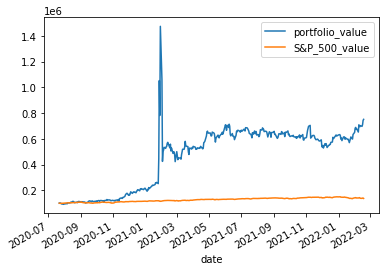

In [18]:
account = Account(100000, time='open', model=model)
print("start date: ", dates[0])
print("end date: ", dates[-1])
time='open'
for i in range(len(dates)):
    sample_df = sp_df.loc[dates[i]]
    if i > 0 and time == "close":
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])
    
    # Updating strategy after close
    hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    sample_df = sample_df[~sample_df[[f'pct_change_{time}', 'five_day_mean', 'five_day_var', 'twenty_day_mean', 'twenty_day_var']\
        ].isin([np.nan, np.inf, -np.inf]).any(1)]
    sample_df['cluster'] = hc.fit_predict(sample_df[[f'pct_change_{time}', 'five_day_mean']])
    df_0 = sample_df[sample_df['cluster'] == 0]
    df_0.name = 0
    df_1 = sample_df[sample_df['cluster'] == 1]
    df_1.name = 1
    df_2 = sample_df[sample_df['cluster'] == 2]
    df_2.name = 2
    df_3 = sample_df[sample_df['cluster'] == 3]
    df_3.name = 3

    tu_cent, td_cent, mru_cent, mrd_cent = find_centers(df_0, df_1, df_2, df_3, time='open')
    dfs = [df_0, df_1, df_2, df_3]

    for df in dfs:
        if df.name == tu_cent['name']:
            account.set_outlier_pos('tu', td_cent, mru_cent, mrd_cent, df)
        elif df.name == td_cent['name']:
            account.set_outlier_pos('td', tu_cent, mru_cent, mrd_cent, df)
        elif df.name == mru_cent['name']:
            account.set_outlier_pos('mru', tu_cent, td_cent, mrd_cent, df)
        else:
            account.set_outlier_pos('mrd', tu_cent, td_cent, mru_cent, df)

    if time == 'open':
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])

account.close_positions(sp_df.loc[dates[i]])
account.get_profit()
account.get_annualized_returns()
account.get_winrate()
account.get_mean_winning_gain()
account.get_mean_losing_loss()
account.get_sharpe_ratio(0.03)
account.get_drawdown()
account.get_alpha(0.03)
account.gen_account_value_plot()

start date:  2020-07-22 00:00:00
end date:  2022-02-17 00:00:00
Profit:  -23062.23446035385
Annualized Returns:  -0.15331205052650676
Winrate:  0.49530864197530866
Percent Gain on Winning Trades:  0.5368445408178326
Percent Loss on Losing Trades:  0.4396927716995111
Sharpe Ratio:  -0.3600651724827688
Max drawdown:  131197.05223703384
Max drawdown length:  267
Alpha:  0.12423290820029656


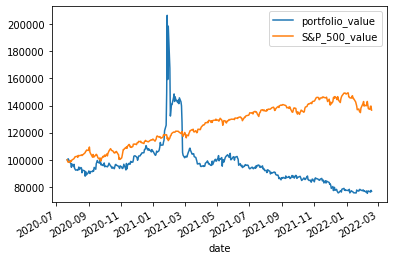

In [19]:
account = Account(100000, time='open', model=None)
print("start date: ", dates[0])
print("end date: ", dates[-1])
time='open'
for i in range(len(dates)):
    sample_df = sp_df.loc[dates[i]]
    if i > 0 and time == "close":
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])
    
    # Updating strategy after close
    hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
    sample_df = sample_df[~sample_df[[f'pct_change_{time}', 'five_day_mean', 'five_day_var', 'twenty_day_mean', 'twenty_day_var']\
        ].isin([np.nan, np.inf, -np.inf]).any(1)]
    sample_df['cluster'] = hc.fit_predict(sample_df[[f'pct_change_{time}', 'five_day_mean']])
    df_0 = sample_df[sample_df['cluster'] == 0]
    df_0.name = 0
    df_1 = sample_df[sample_df['cluster'] == 1]
    df_1.name = 1
    df_2 = sample_df[sample_df['cluster'] == 2]
    df_2.name = 2
    df_3 = sample_df[sample_df['cluster'] == 3]
    df_3.name = 3

    tu_cent, td_cent, mru_cent, mrd_cent = find_centers(df_0, df_1, df_2, df_3, time='open')
    dfs = [df_0, df_1, df_2, df_3]

    for df in dfs:
        if df.name == tu_cent['name']:
            account.set_outlier_pos('tu', td_cent, mru_cent, mrd_cent, df)
        elif df.name == td_cent['name']:
            account.set_outlier_pos('td', tu_cent, mru_cent, mrd_cent, df)
        elif df.name == mru_cent['name']:
            account.set_outlier_pos('mru', tu_cent, td_cent, mrd_cent, df)
        else:
            account.set_outlier_pos('mrd', tu_cent, td_cent, mru_cent, df)

    if time == 'open':
        # making trades on open
        # can only trade after setting initial values
        account.make_trades(sample_df)
        account.update_value(sample_df, sp_500_df.loc[dates[i]])

account.close_positions(sp_df.loc[dates[i]])
account.get_profit()
account.get_annualized_returns()
account.get_winrate()
account.get_mean_winning_gain()
account.get_mean_losing_loss()
account.get_sharpe_ratio(0.03)
account.get_drawdown()
account.get_alpha(0.03)
account.gen_account_value_plot()